# Digit Recogniser using CNN in Keras
<b><i>Source: <a href="https://www.kaggle.com/c/digit-recognizer/"> Kaggle Digit Recognizer Competition</a></i></b>

<img src="https://miro.medium.com/max/718/1*4TJWlK-FPhskEIJshfEx5g.jpeg">

Modified National Institute of Standards and Technology (MINST) is the *de facto* *“hello world”* dataset of computer vision. <br>
Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. <br>
As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.

## 1. <a id="Section1">Setup</a>
### 1.1. <a id="Section1.1">Load Libraries</a>

In [1]:
# BASE
import pandas as pd
import numpy as np

# VISUALISATION
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import seaborn as sns

# TRAINING & TESTING
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DEEP LEARNING
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

# EVALUATION
from keras.utils.np_utils import to_categorical

## Check GPU
if tf.test.is_gpu_available() == True: print('GPU Available')
else: print("No GPU found")

Using TensorFlow backend.


GPU Available


### 1.2. <a id="Section1.2">Load Dataset</a>
The data files *train.csv* and *test.csv* contain grayscale images of hand-drawn digits, from $0$ through $9$.

Each image is $28$ pixels in height and $28$ pixels in width, for a total of $784$ pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between $0$ and $255$, inclusive.

The training data set, (*train.csv*), has $785$ columns. The first column, called *"label"*, is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like $pixel_x$, where $x$ is an integer between $0$ and $783$, inclusive. To locate this pixel on the image, suppose that we have decomposed $x$ as $x = i * 28 + j$, where $i$ and $j$ are integers between $0$ and $27$, inclusive. Then $pixel_x$ is located on row $i$ and column $j$ of a $28$ x $28$ matrix, (indexing by zero).

The test data set, *test.csv*, is the same as the training set, except that it does not contain the *"label"* column.

In [2]:
# LOAD
train = pd.read_csv('../input/digit-recognizer/train.csv')
test = pd.read_csv('../input/digit-recognizer/test.csv')
submission = pd.read_csv('../input/digit-recognizer/sample_submission.csv')

In [3]:
# SEPARATE LABELS
X = train.drop(['label'], 1).values
y = train['label'].values
test_x = test.values

## 2. <a id="Section2">Data Engineering</a>
Part of the data engineering process involves shaping the data into something meaningful and usable in the modelling process.

This involves, but isn't limited to, correcting data errors, reshaping, and feature engineering.

In our case, we will be focusing on feature engineering whereby the dataset's current features will be transformed into more meaningful features and artificially augmenting the dataset with new instances.

### 2.1. <a id="Section2.1">Grayscale Reshape and Encoding</a>
* Transform images to grayscale (grayscale normalisation: divide by 255). <br>
  Reduces effect of lighting differences.
* Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1). <br>
  Grayscale: `canal = 1`
* Encode labels to one-hot vectors for algorithm to classify.

In [4]:
# GRAYSCALE NORMALISATION
X = X / 255.0
test_x = test_x / 255.0

# RESHAPE
X = X.reshape(-1,28,28,1)
test_x = test_x.reshape(-1,28,28,1)

# ONE-HOT ENCODING
y = to_categorical(y)

### 2.2. <a id="Section2.2">Training-Test Split</a>
* Training to Test Ratio:<br>
  90% - 10%

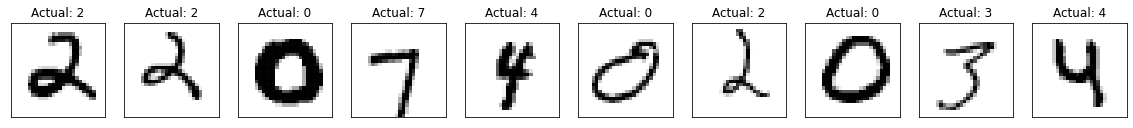

In [35]:
# SPLIT DATASET
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# VIEW OUTPUTS
fig, axis = plt.subplots(1, 10, figsize=(20, 5))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_train.reshape(X_train.shape[0], 28, 28)[i], cmap='binary')
    digit = y_train[i].argmax()
    ax.set(title = f"Actual: {digit}")
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

### 2.3. <a id="Section2.3">Data Augmentation</a>
<ul>
<li>More data reduces the risk of overfitting, however, it is impossible to collect more examples of handwritten digits in our case.
<li>A workaround would be to artificially increase the dataset's size by creating variations of the existing instances. <br>
    These variations would simulate the differences between different writing styles (slanted left, slanted right, bigger font, smaller font, etc...).
<li>This can be achieved via a series of transformations such as rotations, zooms, shifts, and so on...
<li>Each existing instance can therefore be used to create numerous additional instances which will then increase the dataset's size and thus reduce overfitting.<br>

<br>
<li><b>Random Transformations Applied</b>
    <ul><li> Zoom: 10%
        <li> Rotate: 10$^{\circ}$
        <li> Vertical Shift: 10% of height
        <li> Horizontal Shift: 10% of width
    </ul>
    

In [6]:
# DEFINE AUGMENTATION PARAMETERS
_batchsize = 64
dataaug = ImageDataGenerator(zoom_range = 0.1,                     # RANDOM ZOOM
                             rotation_range = 10,                  # RANDOM ROTATION
                             width_shift_range = 0.1,              # RANDOM HORIZONTAL SHIFT
                             height_shift_range = 0.1,             # RANDOM VERTICAL SHIFT
                             zca_whitening = False,                # APPLY ZCA WHITENING
                             vertical_flip = False,                # RANDOM VERTICAL FLIP
                             horizontal_flip = False,              # RANDOM HORIZONTAL FLIP
                             featurewise_center = False,           # SET INPUT MEAN TO 0 OVER DATASET
                             samplewise_center  = False,           # SET EACH SAMPLE MEAN TO 0
                             samplewise_std_normalization = False, # DIVIDE EACH INPUT BY ITS STD
                             featurewise_std_normalization = False # DIVIDE INPUTS BY DATASET STD
                            )                 

# AUGMENT DATASET
train_aug = dataaug.flow(X_train, y_train, batch_size = _batchsize)
test_aug  = dataaug.flow(X_test,  y_test,  batch_size = _batchsize)

## 3. <a id="Section3">Convolutional Neural Network</a>
<b><i>Source: <a href="https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/"> An Intuitive Explanation of Convolutional Neural Networks (Ujjwalkarn, 2016)</a></i></b>

CNNs derive their name from the *“convolution”* operator. The primary purpose of convolution in a CNN is to extract features from the input image. Convolution preserves the spatial relationship between pixels by learning image features using small squares of input data.

**TL;DR**<br>
CNNs have 4 major operations: *Convolution, ReLU, Pooling,* and *Classification.*

The first 3 layers extract the useful features from the images, introduce non-linearity in our network, and reduce feature dimension while aiming to make the features somewhat equivariant to scale and translation. <br>
The output from the last *Pooling* layer acts as an input to the *Fully Connected* layer which is basically a *Multi Layer Perceptron* (MLP) classifier.

<b><u>CNN Operations:</u></b><br>
<b>1. Convolution Step (*Conv2D*)</b><br>
A filter scans the image's pixel values and creates a *Feature Map* <br>
<img src="https://ujwlkarn.files.wordpress.com/2016/07/convolution_schematic.gif?w=268&h=196" alt="Convolution Process">

In CNN terminology, the 3×3 matrix is called a ‘filter‘ or ‘kernel’ or ‘feature detector’ and the matrix formed by sliding the filter over the image and computing the dot product is called the ‘Convolved Feature’ or ‘Activation Map’ or the ‘Feature Map‘. It is important to note that filters acts as feature detectors from the original input image.

It is evident from the animation above that different values of the filter matrix will produce different Feature Maps for the same input image. 

<b>2. Non Linearity (ReLU) Step</b><br>
<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-2-23-48-am.png?w=537&h=168" alt="ReLU Process">

ReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero. The purpose of ReLU is to introduce non-linearity in our ConvNet, since most of the real-world data we would want our ConvNet to learn would be non-linear (Convolution is a linear operation – element wise matrix multiplication and addition, so we account for non-linearity by introducing a non-linear function like ReLU).

<b>3. Pooling Step</b><br>
<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-10-at-3-38-39-am.png?w=494" alt="Max Pooling Process" width="400px">

Spatial Pooling (subsampling or downsampling) reduces the dimensionality of each feature map but retains the most important information. In case of Max Pooling, we define a spatial neighborhood (for example, a 2×2 window) and take the largest element from the rectified feature map within that window.

Amongst other advantages, pooling makes the input representations (feature dimension) smaller and more manageable; and reduces the number of parameters and computations in the network, therefore, controlling overfitting.

<b>4. Fully Connected Layer (Classification)</b><br>
<img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-08-at-2-26-09-am.png?w=748" alt="CNN Architecture"><br>

This layer is a *MLP* that uses a *softmax* activation function in the output layer. The term *“Fully Connected”* implies that every neuron in the previous layer is connected to every neuron on the next layer.

The output from the convolutional and pooling layers represent high-level features of the input image. The purpose of the Fully Connected layer is to use these features for classifying the input image into various classes based on the training dataset.

### 3.1. <a id="Section3.1">Model Specification</a>
<ul>
<li><b>Conv2D Layers</b>
    <ul>
        <li> Layers 1-2: 64 filters
        <li> Layers 3-4: 128 filters
        <li> Layers 5-6: 256 filters
    </ul>

<li><b>MaxPool2D Layers</b>
    <ul>
        <li> 3 Max Pooling layers with spatial neighbourhood = 2x2 window
        <li> Conv2D and MaxPool2D layers are alternated
    </ul>

<li><b>Fully Connected Layer</b>
    <ul>
        <li> Flattening Layer: Combines the final feature maps into a one single 1D vector to be passed to Dense Layer.
        <li> Dense Layer 1: MLP classifier `Dense(512,activation="relu")`
        <li> Dense Layer 2: Probability calculation `Dense(10,activation="softmax")`
    </ul>

<li><b>Non Linearity (Retified Linear Unit)</b><br>
    <ul>
        <li>`relu` is the rectifier activation function $\max(0,x)$. <br>
        <li>The function is used to add non linearity to the network.
    </ul>

In [7]:
# TRAINING EPOCHS
_epochs = 50

# CNN SPECIFICATION
model=Sequential()

## Convolutional Layers 1-2
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(28,28,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))

## Pooling Layer 1
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

## Convolutional Layers 3-4
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))

## Pooling Layer 2
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization()) 

## Convolutional Layers 1-2
model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))

## Pooling Layer 3
model.add(MaxPooling2D(pool_size=(2,2)))

## Fully Connected Layer
model.add(Flatten())
model.add(BatchNormalization())

model.add(Dense(512,activation="relu"))
model.add(Dense(10,activation="softmax"))

## Compile
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
# CNN ARCHITECTURE
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### 3.2. <a id="Section3.2">Training Stage</a>

In [8]:
history = model.fit_generator(train_aug, 
                              epochs = _epochs, 
                              steps_per_epoch = X_train.shape[0] // _batchsize,
                              validation_data = test_aug,
                              validation_steps = X_test.shape[0] // _batchsize
                             )

Epoch 1/50
590/590 [==============================] - 20s 34ms/step - loss: 0.1597 - accuracy: 0.9499 - val_loss: 0.0460 - val_accuracy: 0.9565
Epoch 2/50
590/590 [==============================] - 16s 27ms/step - loss: 0.0694 - accuracy: 0.9791 - val_loss: 0.0161 - val_accuracy: 0.9739
Epoch 3/50
590/590 [==============================] - 15s 26ms/step - loss: 0.0563 - accuracy: 0.9830 - val_loss: 0.0258 - val_accuracy: 0.9840
Epoch 4/50
590/590 [==============================] - 15s 26ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0992 - val_accuracy: 0.9794
Epoch 5/50
590/590 [==============================] - 15s 26ms/step - loss: 0.0412 - accuracy: 0.9881 - val_loss: 0.0142 - val_accuracy: 0.9850
Epoch 6/50
590/590 [==============================] - 16s 28ms/step - loss: 0.0384 - accuracy: 0.9886 - val_loss: 0.0325 - val_accuracy: 0.9768
Epoch 7/50
590/590 [==============================] - 15s 26ms/step - loss: 0.0374 - accuracy: 0.9886 - val_loss: 0.0039 - val_accuracy:

## 4. <a id="Section4">Evaluation</a>
### 4.1. <a id="Section4.1">Model Diagnostic</a>

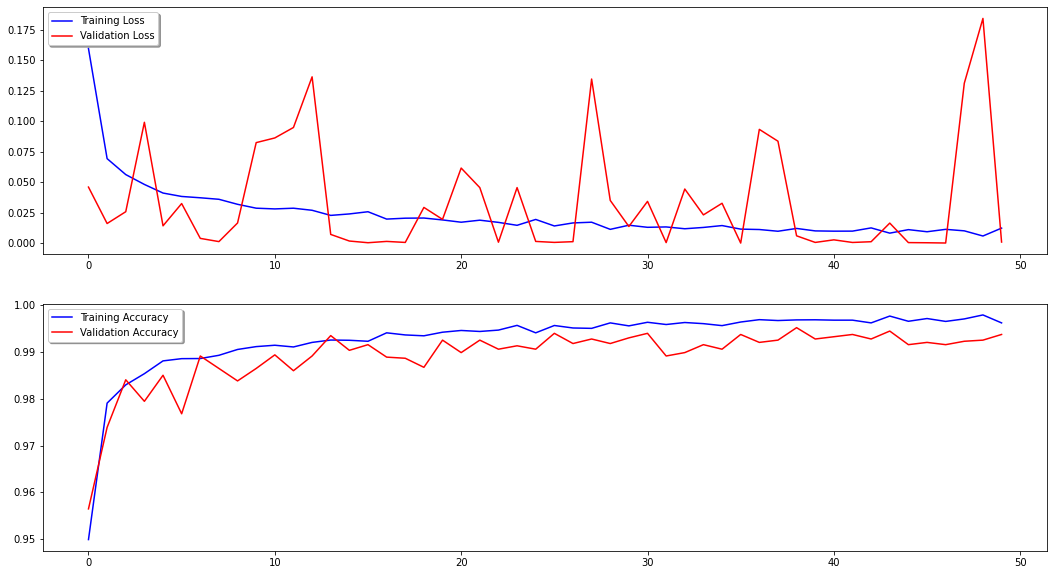

In [39]:
fig, ax = plt.subplots(2,1, figsize=(18, 10))
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.2. <a id="Section4.2">Testing Stage</a>

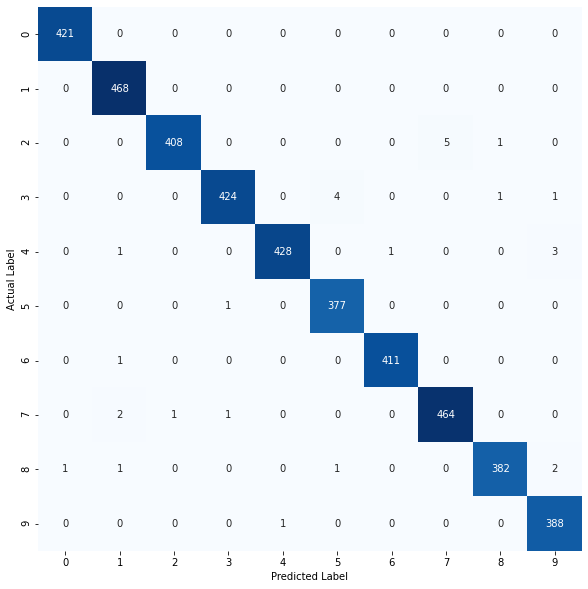

In [44]:
# CONFUSION MATRIX
y_pred = model.predict(X_test)
c_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))

# PLOT
fig = plt.figure(figsize=(10, 10))
sns.heatmap(c_matrix.T, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label');
plt.show();

### 4.3. <a id="Section4.3">Visual Inspection</a>

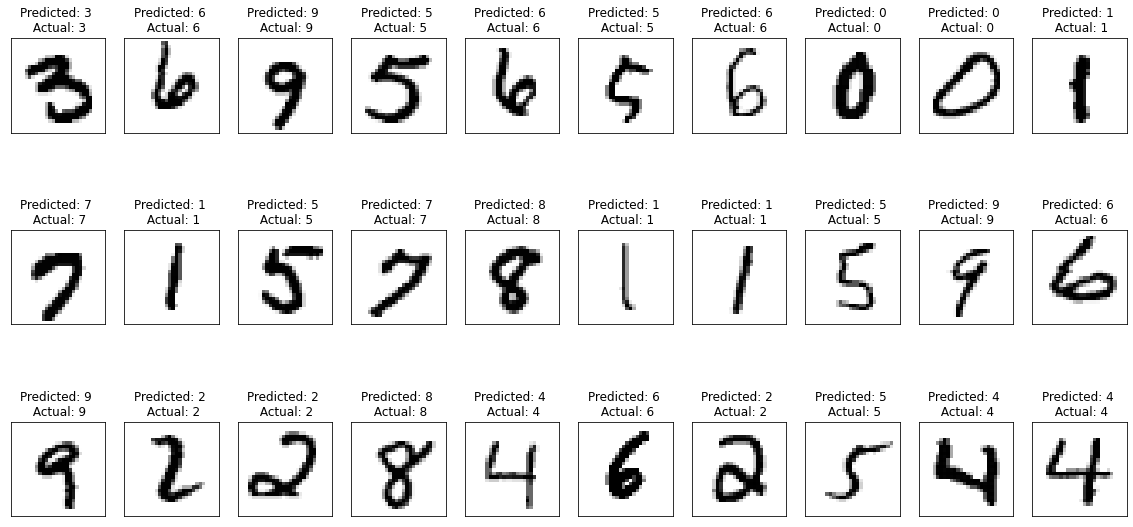

In [34]:
fig, axis = plt.subplots(3,10, figsize=(20, 10))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test.reshape(X_test.shape[0], 28, 28)[i], cmap='binary')
    ax.set(title = f"Predicted: {y_pred[i].argmax()} \n Actual: {y_test[i].argmax()}")
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

## 5. <a id="Section5">Predictions</a>
### 5.1. <a id="Section5.1">Model Predictions</a>

In [ ]:
# LOAD RAW SUBMISSION FILE
sub = pd.read_csv('../input/sample_submission.csv')

# PREDICT LABELS & APPEND
pred = model.predict_classes(test_x, verbose=1)
sub['Label'] = pred
#sub.to_csv("CNN_keras_sub.csv", index=False)
#sub.head()

### 5.2. <a id="Section5.2">Visual Inspection</a>

In [ ]:
#asd

### Plotly Versions (Does not render in Github ...)

In [30]:
_epch = [i for i in range(1,51)]

fig = make_subplots(rows=2, cols=1,
                    shared_xaxes = True, vertical_spacing=0.05
                   )

# LOSS
fig.append_trace(go.Scatter(y=history.history['loss'], x=_epch, name='Training Loss',
                            mode='lines', line=dict(color='orange'), 
                            hovertemplate='<b>Epoch %{x}</b>'+ '<br><i>Training Loss</i>: %{y:.3f}<extra></extra>'), 
                 row=1, col=1)
fig.append_trace(go.Scatter(y=history.history['val_loss'], x=_epch, name='Validation Loss', 
                            mode='lines', line=dict(color='firebrick'), 
                            hovertemplate='<b>Epoch %{x}</b>'+ '<br><i>Validation Loss</i>: %{y:.3f}<extra></extra>'), 
                 row=1, col=1)
# ACCURACY
fig.append_trace(go.Scatter(y=history.history['accuracy'], x=_epch, name='Training Accuracy',
                            mode='lines', line=dict(color='darkturquoise'), 
                            hovertemplate='<b>Epoch %{x}</b>'+ '<br><i>Training Accuracy</i>: %{y:.3f}<extra></extra>'), 
                 row=2, col=1)
fig.append_trace(go.Scatter(y=history.history['val_accuracy'], x=_epch, name='Validation Accuracy',
                            mode='lines', line=dict(color='navy'), 
                            hovertemplate='<b>Epoch %{x}</b>'+ '<br><i>Validation Accuracy</i>: %{y:.3f}<extra></extra>'),  
                 row=2, col=1)
# AXIS LABELS
fig.update_traces(xaxis="x2")
fig.update_xaxes(title_text="", showspikes=True, spikecolor="grey", spikesnap="cursor", spikemode="across", row=1, col=1)
fig.update_yaxes(title_text="Training & Validation Loss", row=1, col=1)
fig.update_xaxes(title_text="Epochs", showspikes=True, spikecolor="grey", spikesnap="cursor", spikemode="across", row=2, col=1)
fig.update_yaxes(title_text="Training & Validation Accuracy", row=2, col=1)

# TICKS
fig.update_xaxes(ticktext=[i for i in range(0,51,5)], tickvals=[i for i in range(0,51,5)])

fig.update_layout(height=700)
fig.show()

In [38]:
# CONFUSION MATRIX
y_pred = model.predict(X_test)
c_matrix = confusion_matrix(np.argmax(y_test, 1), np.argmax(y_pred, 1))

# PLOT
fig = ff.create_annotated_heatmap(x=[i for i in range(0,10)], y=[i for i in range(0,10)], z=c_matrix.T, 
                                  colorscale="PuBu", font_colors=['black', 'white'],
                                  hovertemplate='<b>Predicted: %{x}</b>'+ '<br><b>Actual</b>: %{y}<extra></extra>')
fig.update_xaxes(title_text="Predicted Label")
fig.update_yaxes(title_text="Actual Label")
fig.show()